<a href="https://colab.research.google.com/github/ZYuliaA/Computer-vision/blob/main/%D0%94%D0%97_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_5_%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [63]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from glob import glob
%matplotlib inline
from matplotlib import pyplot as plt
import re
from sklearn.metrics import log_loss

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp /gdrive/'MyDrive'/'Компьютерное зрение'/test.zip .

In [65]:
!cp /gdrive/'MyDrive'/'Компьютерное зрение'/train.zip .

In [ ]:
!unzip test.zip
!unzip train.zip

In [68]:
IMG_SIZE = (224, 224)

train_files = glob('/content/train/*.jpg')
test_files = glob('/content/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [69]:
len(train_files), len(test_files)

(25000, 12500)

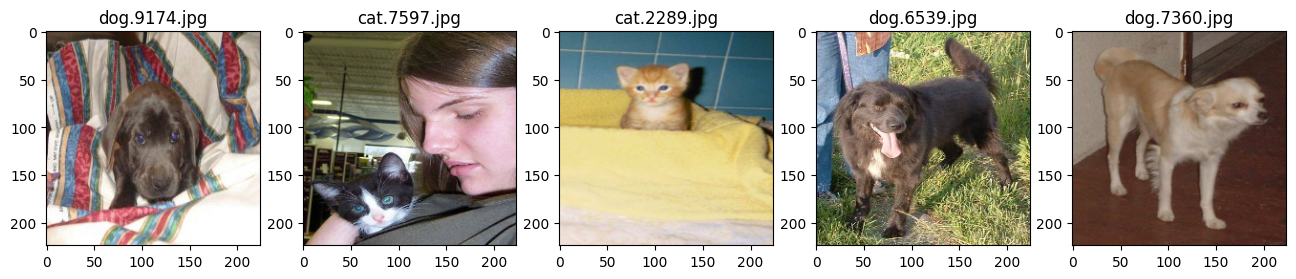

In [70]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:5], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [71]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [ ]:
base_model.summary()

In [72]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1,
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.summary()

In [74]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [75]:
val_samples = 2500

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 18s 2s/step - loss: 1197.0115 - accuracy: 0.5281 - val_loss: 62.0604 - val_accuracy: 0.7676
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 1381.9309 - accuracy: 0.5719 - val_loss: 56.0853 - val_accuracy: 0.6768
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 551.8419 - accuracy: 0.5906 - val_loss: 33.6483 - val_accuracy: 0.8180
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 305.1927 - accuracy: 0.6594 - val_loss: 36.1607 - val_accuracy: 0.7548
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 214.6404 - accuracy: 0.5406 - val_loss: 18.7558 - val_accuracy: 0.8000
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 64.3936 - accuracy: 0.6000 - val_loss: 3.2007 - val_accuracy: 0.6652
Epoch 7/100
10/10 [==============================] - 13s 1s/step - loss: 12.3730 - accuracy: 0.5500 - val_loss: 1.2046 - val_accuracy: 0

In [76]:
model.save('cats-dogs-vgg16.hdf5')

In [77]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

print(np.argmax(test_pred))

12500/12500 [==============================] - 141s 11ms/step
123


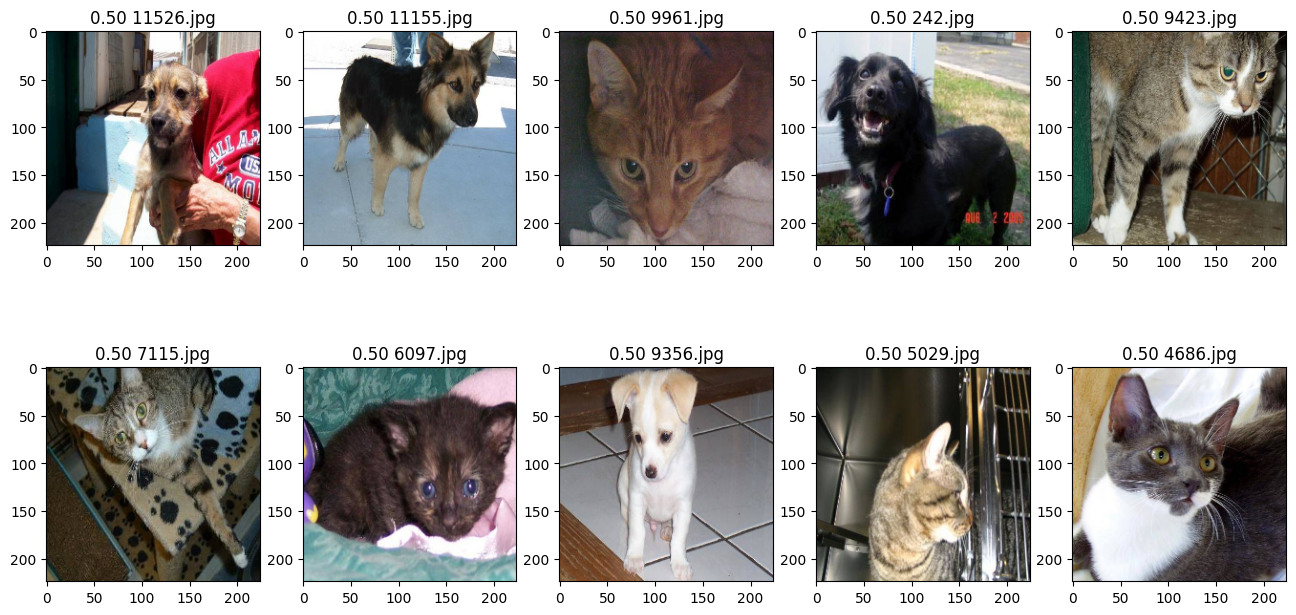

In [81]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[1000:1010], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [79]:
with open('sub.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [82]:
sub = pd.read_csv('sub.csv')
sub

,id,label
0,4993,0.497102
1,7000,0.497102
2,11383,0.497102
3,4997,0.497102
4,1309,0.497102
...,...,...
12495,715,0.497102
12496,4790,0.497102
12497,7577,0.497102
12498,9589,0.497102
